In [1]:
# import the tools we need
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# transforms for images
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5),
    torchvision.transforms.Normalize(mean = [3.89455125276032e-06, 0.00014938852662573483, 0.005843691424839318], 
    std = [0.28401965297405607, 0.25763376048862824, 0.212752166246306])
])


# datasets
trainset = torchvision.datasets.ImageFolder("../input/dog-50-breed/train", transform = transforms)
#validset = torchvision.datasets.ImageFolder("./val", transform = transforms)
testset = torchvision.datasets.ImageFolder("../input/dog-50-breed/test", transform = transforms)

#batches 
batch_size = 64                             #128 when parameters are freezed and 64 when train from scratch

# loaders for data
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , shuffle = True)
#validloader = torch.utils.data.DataLoader(validset , batch_size=batch_size , shuffle = True)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size)

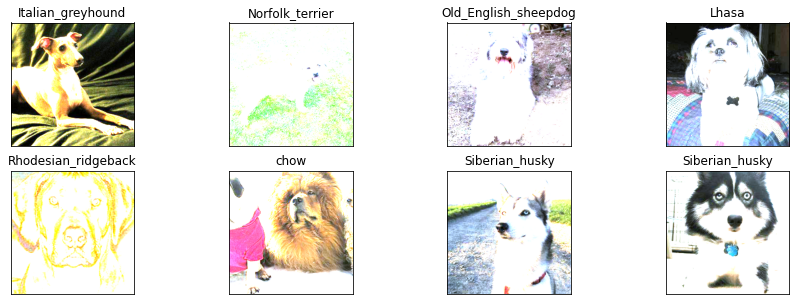

In [3]:
images, labels = iter(trainloader).next()
images, labels = images.numpy() , labels.numpy()

fig = plt.figure(figsize = (15,5))

for i in range(int(batch_size/8)):
    ax = fig.add_subplot(2 , int(batch_size/16) , i + 1 , xticks = [] , yticks = [])
    ax.imshow(np.transpose(images[i] , (1,2,0)) , cmap = 'gray')
    ax.set_title(trainset.classes[labels[i]])

In [3]:
# Single batch
print("number of train batches : ", len(trainloader))
#print("number of validation batches : ", len(validloader))
print("Size of test batches : ", len(testloader))

number of train batches :  121
Size of test batches :  32


In [4]:
print("Unique classes number : ",len(trainset.classes))
print("Classes : ", trainset.classes)

Unique classes number :  50
Classes :  ['Afghan_hound', 'Airedale', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Boston_bull', 'Dandie_Dinmont', 'EntleBucher', 'Great_Pyrenees', 'Ibizan_hound', 'Irish_terrier', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_English_sheepdog', 'Pembroke', 'Pomeranian', 'Rhodesian_ridgeback', 'Saluki', 'Samoyed', 'Scottish_deerhound', 'Sealyham_terrier', 'Shih-Tzu', 'Siberian_husky', 'Tibetan_terrier', 'West_Highland_white_terrier', 'basenji', 'basset', 'beagle', 'bloodhound', 'cairn', 'chow', 'malamute', 'miniature_pinscher', 'papillon', 'pug', 'silky_terrier', 'toy_terrier', 'whippet']


In [5]:
# Whether to train on a gpu
my_gpu = torch.cuda.is_available()
print(f'Train on gpu: {my_gpu}')
device = torch.device('cuda' if my_gpu else 'cpu')

Train on gpu: True


In [6]:
from torchvision import models
import torch.nn.functional as F
import torch.nn as nn
# Use resnet-50 as a base model
class net(torch.nn.Module):
    def __init__(self, base_model, base_out_features, num_classes):
        super(net,self).__init__()
        self.base_model=base_model
        self.linear1 = torch.nn.Linear(base_out_features, 512)
        self.output = torch.nn.Linear(512,num_classes)
    def forward(self,x):
        x = F.relu(self.base_model(x))
        x = F.relu(self.linear1(x))
        x = self.output(x)
        return x

res = torchvision.models.resnet50(pretrained=False)

#for param in res.parameters():
#    param.requires_grad=False

model = net(base_model=res, base_out_features=res.fc.out_features, num_classes=50)
model = model.to(device)

In [7]:
from torch import optim
# Cost function and optimzier
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr = lr)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.1)

# Epoch 
EPOCHS = 30

In [8]:
#format class

class color_formats:
    """
    Simple color formating:
    Variables:
        >OKCYAN - cyan printing.
        >Bold - bold printing.
        >UNDERLINE - underline printing.
    """
    OKCYAN = '\033[96m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [10]:
from timeit import default_timer as timer

def train_loop(model,
          criterion,
          optimizer,
          train_loader,
          save_model_name,
          max_epochs_stop=100,
          num_epochs=100,
          num_epochs_report=1):
    """Train a neural network Model
    Args
    --------
        >model (Pytorch nn model): The neural network for the training process.  
        >criterion (Pytorch loss function): Initialize the loss function.
        >optimizer (Pytorch optimizer): Use an optimizer to compute gradients to update the weights.
        >train_loader (Pytorch dataloader): training dataloader to iterate through.
        >save_model_name (str): file path to save the model state dict, file name ends with 'pt.'.
        >max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping.
        >num_epochs (int): maximum number of training epochs if the early stopping is not activated.
        >num_epochs_report (int): frequency of epochs to print training reports.
    
    outputs
    --------
        >model (PyTorch model): Trained neural networks with best weights.
        >history (DataFrame): History of train and validation loss and accuracy.
    """


    history = []

    # Number trained epochs  (while using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'{color_formats.BOLD + color_formats.UNDERLINE}Training activated:{color_formats.ENDC}\n')

    overall_start = timer()

    # Start of loop
    for epoch in range(num_epochs):

        # Track of training and validation loss for each epoch
        train_loss = 0.0

        train_acc = 0

        # Set model to train
        model.train()
        
        #start timer
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Put the data in the gpu
            if my_gpu:
                data, target = data.to(device), target.to(device)

            # Remove past gradients
            optimizer.zero_grad()
            # Predicted outputs as log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target.long())
            loss.backward()

            # Update the weights
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Training progress tracker
            print(
                f'Epoch: {epoch+1}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')


        # Start validation after training loops ends.
        else:
            model.epochs += 1

            # Deactivate the gradient tracking. 
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

            
                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)

                history.append([train_loss, train_acc])

                # Print training and validation results for the num_epochs_report that was set
                if (epoch + 1) % num_epochs_report == 0:
                    print(
                        f'Epoch: {color_formats.BOLD}{epoch+1}{color_formats.ENDC} \tTraining Loss: {color_formats.BOLD}{train_loss:.4f}{color_formats.ENDC}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {color_formats.BOLD}{100 * train_acc:.2f}%{color_formats.ENDC}\n'
                    )


    # Record overall time and print out Report
    total_time = timer() - overall_start
    
    # History update
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'train_acc'])
    return model, history

In [11]:
# Start Training
# Running the model
model, history = train_loop(
    model,
    criterion,
    optimizer,
    trainloader,
    save_model_name="./dog_resnet50_90_breed_scratch.pt",
    max_epochs_stop=100,
    num_epochs=100,
    num_epochs_report=1)

Training activated:



Epoch: 1 	Training Loss: 3.9234

		Training Accuracy: 2.25%



Epoch: 2 	Training Loss: 3.8176

		Training Accuracy: 3.54%



Epoch: 3 	Training Loss: 3.7545

		Training Accuracy: 3.75%



Epoch: 4 	Training Loss: 3.7058

		Training Accuracy: 4.37%



Epoch: 5 	Training Loss: 3.6383

		Training Accuracy: 6.03%



Epoch: 6 	Training Loss: 3.5809

		Training Accuracy: 6.43%



Epoch: 7 	Training Loss: 3.5255

		Training Accuracy: 7.77%



Epoch: 8 	Training Loss: 3.4676

		Training Accuracy: 8.45%



Epoch: 9 	Training Loss: 3.4088

		Training Accuracy: 9.48%



Epoch: 10 	Training Loss: 3.3337

		Training Accuracy: 10.31%



Epoch: 11 	Training Loss: 3.2629

		Training Accuracy: 11.38%



Epoch: 12 	Training Loss: 3.1926

		Training Accuracy: 12.75%



Epoch: 13 	Training Loss: 3.1486

		Training Accuracy: 14.32%



Epoch: 14 	Training Loss: 3.1168

		Training Accuracy: 14.56%



Epoch: 15 	Training Loss: 3.0343

		Training Accuracy: 15.59%



Epoch: 16 	Training 

In [12]:
torch.save(model,"./dog_resnet50_50_without_val_scratch.pb")

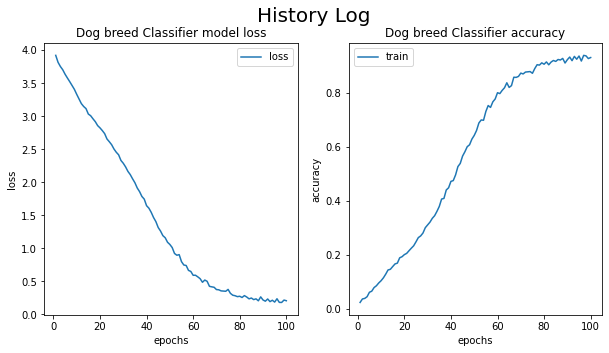

In [13]:
#models logs in detail over time of training.

history.index = [idx for idx in range(1, history.shape[0]+1)] #from first epoch
fig, axs = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('History Log',  size = 20)
#ethnicity model log

axs[0].plot(history["train_loss"], label = "loss")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("loss")
axs[0].legend()
axs[0].set_title('Dog breed Classifier model loss')

axs[1].plot(history["train_acc"], label = "train")
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("accuracy")
axs[1].legend()
axs[1].set_title('Dog breed Classifier accuracy')


plt.show()

In [10]:
def Accuracy_report(loader = None, model = None, n_classes = None):
    """
    Args:
    >loader (pytorch dataloader): the data for accuracy testing.
    >model (pytorch model) : the neural network.
    >n_classes (int): the number of classes.
    
    Output: 
    > class_acc (dict) : accuracy per classes. non existant taregts in the test set are set to nan value.
    > acc (float): overall accuracy.
    """
    my_classes = []

    classes = [n_class for n_class in range(n_classes)]
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        for data in loader:
            inputs, targets = data 
            inputs = inputs.to(device)
            targets = targets.to(device)           
            outputs = model(inputs)    
            _, predictions = torch.max(outputs, 1)

            # collect the correct predictions for each class
            for target, prediction in zip(targets, predictions):
                if target == prediction:
                    correct_pred[classes[target]] += 1
                total_pred[classes[target]] += 1

    for classname, correct_count in correct_pred.items():
        try:
            accuracy =( 100 * float(correct_count) / total_pred[classname] )
            my_classes.append(accuracy)
        except ZeroDivisionError:
            my_classes.append(np.nan)
            continue
    
    acc =  round(100 * float(sum(correct_pred.values())/sum(total_pred.values())),2)
    class_acc = dict(zip(classes,[round(mc,2) for mc in my_classes]))
    return class_acc, acc

def test_report(class_acc,acc):
    """
    Args:
        > my_classes (dict) : accuracy per classes. non existant taregts in the test set are set to nan value.
        > acc (float): overall accuracy.
    
    Output:
        >report of test performance.
    """    
    print(f"{color_formats.BOLD + color_formats.UNDERLINE}Test Accuracy Report{color_formats.ENDC}")
    for key,value in class_acc.items():
        print(f"Class {trainset.classes[key]} has achived {color_formats.BOLD}{value}%{color_formats.ENDC} accuracy\n")
    print(f"Overall accuracy: {color_formats.BOLD}{acc}%{color_formats.ENDC}")
    

In [11]:
m1_test_class_acc, m1_test_acc = Accuracy_report(loader = testloader,model = model, n_classes = 50)
test_report(m1_test_class_acc,m1_test_acc)

Test Accuracy Report
Class Afghan_hound has achived 64.0% accuracy

Class Airedale has achived 62.44% accuracy

Class Australian_terrier has achived 51.2% accuracy

Class Bedlington_terrier has achived 73.8% accuracy

Class Bernese_mountain_dog has achived 96.71% accuracy

Class Blenheim_spaniel has achived 59.08% accuracy

Class Boston_bull has achived 76.11% accuracy

Class Dandie_Dinmont has achived 85.33% accuracy

Class EntleBucher has achived 91.58% accuracy

Class Great_Pyrenees has achived 91.29% accuracy

Class Ibizan_hound has achived 72.21% accuracy

Class Irish_terrier has achived 65.83% accuracy

Class Irish_wolfhound has achived 39.82% accuracy

Class Italian_greyhound has achived 62.27% accuracy

Class Japanese_spaniel has achived 85.33% accuracy

Class Kerry_blue_terrier has achived 89.95% accuracy

Class Labrador_retriever has achived 43.89% accuracy

Class Lakeland_terrier has achived 49.95% accuracy

Class Leonberg has achived 48.76% accuracy

Class Lhasa has achived

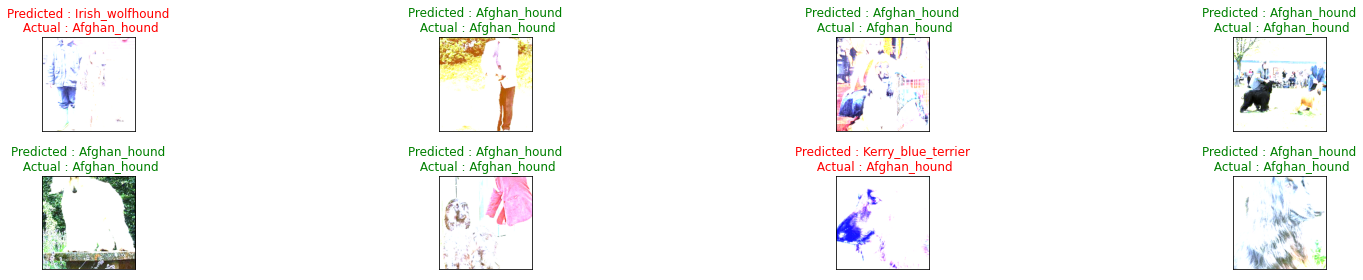

In [20]:
dataiter = iter(testloader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(int(batch_size/8)):
    ax = fig.add_subplot(2, int(batch_size/16), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx].transpose(1,2,0)), cmap='gray')
    ax.set_title("Predicted : {}\n Actual : {}".format(trainset.classes[preds[idx]], trainset.classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))
plt.tight_layout()

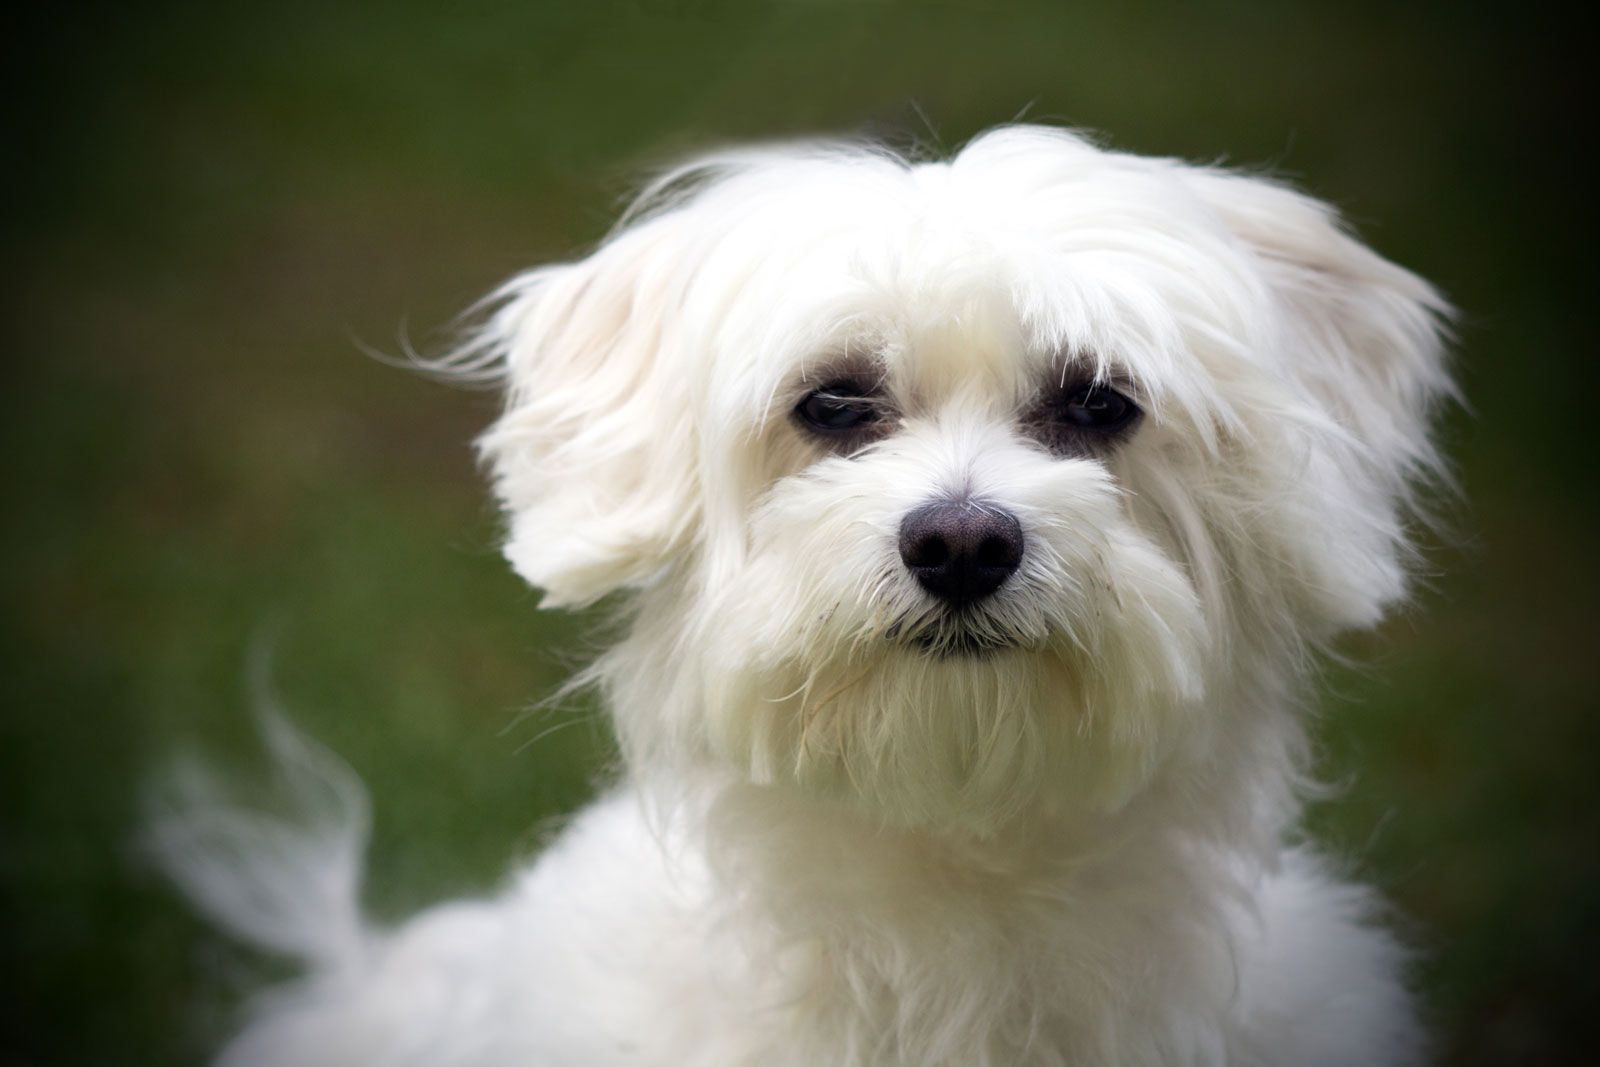

In [21]:
import requests
from io import BytesIO
url = "https://cdn.britannica.com/73/234473-050-5BAFEBF0/Maltese-dog.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

In [23]:
mean = [3.89455125276032e-06, 0.00014938852662573483, 0.005843691424839318]
std = [0.28401965297405607, 0.25763376048862824, 0.212752166246306]

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5),
    torchvision.transforms.Normalize(mean,std)
])


def predictor(img, n=5):
    """
    Args: 
        >img - the image to predict.
        >n - number of top probabilities.
    
    Outputs:
        >pred - the top prediction.
        > top preds - top n predictions.
    """
    #transform the image
    img = transforms(img)
    # get the class predicted 
    pred = int(np.squeeze(model(img.unsqueeze(0).cuda()).data.max(1, keepdim=True)[1].cpu().numpy()))
    # the number is also the index for the class label
    pred = trainset.classes[pred]
    # get model log probabilities
    preds = torch.from_numpy(np.squeeze(model(img.unsqueeze(0).cuda()).data.cpu().numpy()))
    # convert to prediction probabilities of the top n predictions
    top_preds = torch.topk(torch.exp(preds),n)
    #display at an orgenized fasion
    top_preds = dict(zip([trainset.classes[i] for i in top_preds.indices],[f"{round(float(i)*100,2)}%" for i in top_preds.values]))
    return pred, top_preds

In [24]:
my_prediction, top_predictions = predictor(img, n=5)
print(my_prediction)

Maltese_dog


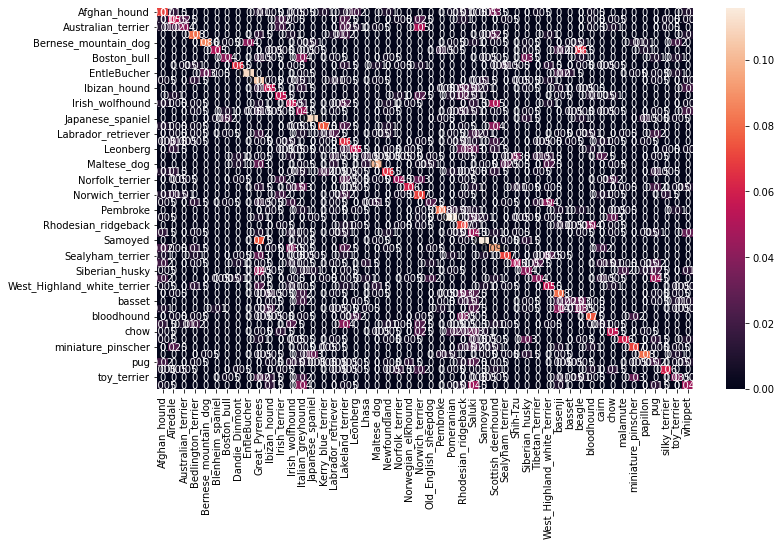

In [12]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []


# iterate over test data
for images, labels in testloader:
        output = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = trainset.classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('./confusion_mobilenetv2.png')

In [19]:
from sklearn.metrics import accuracy_score, classification_report

# print accuracy
print("Overall Accuracy: ", round(accuracy_score(y_true, y_pred)*100,2)," %")

# print precision, recall, F1-score per each class/tag
metrices=classification_report(y_true, y_pred,target_names=trainset.classes)

class_data = list()
accuracy_data = list(m1_test_class_acc.values())
precision_data = list()
recall_data = list()
f1_data = list()
support_data = list()
lines = metrices.split('\n')
for line in lines[2:-5]:
    row_data = line.split('      ')
    #print(row_data)
    class_data.append(row_data[-5])
    precision_data.append(float(row_data[-4]))
    recall_data.append(float(row_data[-3]))
    f1_data.append(float(row_data[-2]))
    support_data.append(float(row_data[-1]))
#print(classification_report(y_true, y_pred,target_names=trainset.classes)[1])

Overall Accuracy:  68.5  %


In [25]:
precision_data=[round(i,2) for i in precision_data]
recall_data=[round(i,2) for i in recall_data]
f1_data=[round(i,2) for i in f1_data]

In [26]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [27]:
#ROC_AUC score
roc_auc_dict = roc_auc_score_multiclass(y_true, y_pred)
roc_auc_data=list(roc_auc_dict.values())
#final_roc_auc_dictionary=dict(zip(list(trainset.classes) ,list(roc_auc_dict.values())) )

In [28]:
roc_auc_data=[round(i,2)*100 for i in roc_auc_data]

In [32]:
from prettytable import PrettyTable
from statistics import mean
# Creating instance of PrettyTable class
my_table = PrettyTable(['Class','Accuracy','Precision','Recall','F1 Score','Support','ROC_AUC Score'])
for i in range(len(class_data)):
    my_table.add_row([class_data[i],accuracy_data[i],precision_data[i],recall_data[i],f1_data[i],support_data[i],roc_auc_data[i] ])
    

# Printing the tabulated list
print(my_table)

second_table = PrettyTable(['Overall\t\t     ',str(round(m1_test_acc,2))+"\t",str(round(mean(precision_data),2))+"    ",
                           str(round(mean(recall_data),2))+" ",str(round(mean(f1_data),2))+"\t",' --\t  ',str(round(mean(roc_auc_data),2))+"\t  "])

print(second_table)


+-----------------------------+----------+-----------+--------+----------+---------+---------------+
|            Class            | Accuracy | Precision | Recall | F1 Score | Support | ROC_AUC Score |
+-----------------------------+----------+-----------+--------+----------+---------+---------------+
|          Afghan_hound       |   64.0   |   63.25   |  49.3  |   42.5   |   48.0  |      63.0     |
|           Airedale          |  62.44   |    66.0   |  45.9  |   44.2   |   41.0  |      63.0     |
|       Australian_terrier    |   51.2   |    64.6   |  55.0  |   44.2   |   40.0  |      60.0     |
|       Bedlington_terrier    |   73.8   |    61.2   |  73.1  |   66.3   |   37.0  |      71.0     |
|     Bernese_mountain_dog    |  96.71   |    71.0   |  64.6  |   83.3   |   45.0  |      69.0     |
|         Blenheim_spaniel    |  59.08   |    87.1   |  44.2  |   62.9   |   39.0  |      63.0     |
|           Boston_bull       |  76.11   |    71.4   |  60.5  |   49.3   |   37.0  |      6